# Импорты

In [1]:
import pandas as pd
import pymatgen
from pathlib import Path
from sklearn.model_selection import train_test_split
import json
from pymatgen.core import Structure
import tensorflow as tf
import numpy as np

# Определение функций

In [2]:
def read_pymatgen_dict(file):
    with open(file, "r") as f:
        d = json.load(f)
    return Structure.from_dict(d)

In [ ]:
from collections import Counter

def get_structure_info(structure):
    elements = dict(Counter(structure.atomic_numbers))
    num_atoms = 
    masses = [k*v for k, v in elements.items()]
    periodic_numbers = list(elements.keys())
    main_element = periodic_numbers[0]
    volume = structure.volume
    density = structure.density
    full_mass = sum(masses)
    distance_vector = np.array([np.mean(i[i!=0]) for i in structure.distance_matrix])
    
    return np.append(distance_vector, [masses+periodic_numbers+[main_element, volume, density, full_mass]])

In [3]:
def prepare_dataset(dataset_path):
    dataset_path = Path(dataset_path)
    targets = pd.read_csv(dataset_path / "targets.csv", index_col=0)
    struct = {
        item.name.strip(".json"): get_structure_info(read_pymatgen_dict(item))
        for item in (dataset_path / "structures").iterdir()
    }

    data = pd.DataFrame(columns=["structures"], index=struct.keys())
    data = data.assign(structures=struct.values(), targets=targets)

    return train_test_split(data, test_size=0.2, random_state=42)

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def pad_func(dataset):
    max_len = 0
    mean_list = []
    for i in dataset:
        mean_list.append(np.mean(i))
        if len(i)>max_len:
            max_len = len(i)
    return pad_sequences(dataset, value=np.mean(mean_list, dtype=np.float64), dtype=np.float64, padding='post', truncating='post', maxlen=max_len)

In [5]:
def energy_within_threshold(prediction, target):
    # compute absolute error on energy per system.
    # then count the no. of systems where max energy error is < 0.02.
    e_thresh = 0.02
    error_energy = tf.math.abs(target - prediction)

    success = tf.math.count_nonzero(error_energy < e_thresh)
    total = tf.size(target)
    return float(success / tf.cast(total, tf.int64))

In [6]:
#если захочешь передать в какой-нибудь гридсерч эту функцию как оценщика - сделай вот это:
#from sklearn.metrics import make_scorer
#e_score = make_scorer(energy_within_threshold, greater_is_better=True)
#выглядит это, например, вот так:
#from sklearn.model_selection import GridSearchCV
#reg = GridSearchCV(catboost.CatBoostRegressor(), param_grid=param_grid, scoring=e_score)

# Подготовка датасета

In [66]:
train, test = prepare_dataset('dichalcogenides_public')
train_y = train.targets
train_x = pad_func(train.structures)
test_y = test.targets
test_x = pad_func(test.structures)

In [ ]:
def get_marks(ans_list):
    fin = []
    for el in ans_list:
        if el < 0.75:
            fin.append(0)
        elif el < 1.25:
            fin.append(1)
        else:
            fin.append(2)
    return fin

class_train_y = 

In [67]:
train_y

61428b0b4e27a1844a5f0860    1.1454
6141d2649cbada84a8676907    1.8089
6141ef44ee0a3fd43fb47d6f    0.4277
6141ee3b31cf3ef3d4a9f11a    0.4047
61420c4b31cf3ef3d4a9f288    0.3991
                             ...  
614200734e27a1844a5f0512    1.1377
6141e1edbaaf234b35290424    1.0878
6141e34d3ac25c70a5c6c995    0.5370
6141eb2d9cbada84a8676b2b    1.8089
6141d9d1ee0a3fd43fb47c0b    0.4242
Name: targets, Length: 2372, dtype: float64

In [68]:
test_y

614279304e27a1844a5f0810    1.1451
6141d809ee0a3fd43fb47bdf    0.2773
6142191a31cf3ef3d4a9f2f0    0.4159
6141d03e31cf3ef3d4a9edfc    0.3530
614229933ac25c70a5c6cafd    0.4175
                             ...  
61421e50ee0a3fd43fb47eaf    0.3511
6142d48f4e27a1844a5f0948    1.1466
6141f0c4baaf234b352904f6    1.1088
6141d3e94e27a1844a5f0190    1.1479
61425fad31cf3ef3d4a9f4b4    0.4079
Name: targets, Length: 594, dtype: float64

In [70]:
from sklearn.ensemble import RandomForestRegressor
regr_4 = RandomForestRegressor(max_depth=30, min_samples_leaf=2, random_state=42)
regr_4.fit(train_x, train_y)
y_4 = regr_4.predict(test_x)

In [71]:
energy_within_threshold(y_4, test_y)

0.6447811447811448

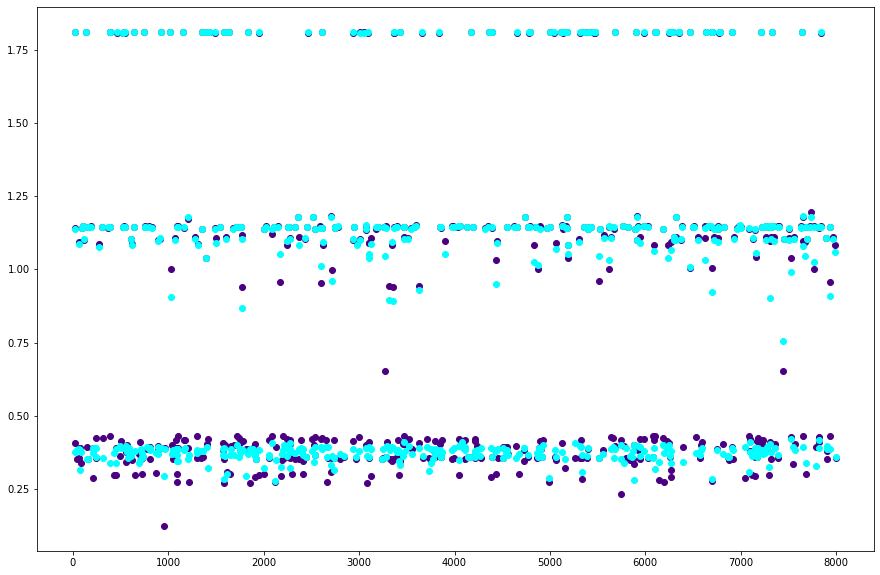

In [52]:
import random
import matplotlib.pyplot as plt
x = [random.randint(1, 8000) for i in range(len(y_4))]
plt.figure(figsize = (15, 10))
plt.scatter(x, test_y, color='#4B0082')
plt.scatter(x, y_4, color='cyan')
plt.show()

In [100]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {'n_estimators': (50, 100, 150, 200),
              'min_samples_leaf': (1, 2, 3),
              'max_depth': (2, 3, 4),
              'max_leaf_nodes': (None, 5, 6, 10),
              'n_iter_no_change': (None, 5)
}

grad = GradientBoostingRegressor(n_estimators=100, max_depth=15)
grad.fit(train_x, train_y)
y_g = grad.predict(test_x)
energy_within_threshold(y_g, test_y)

0.6818181818181818

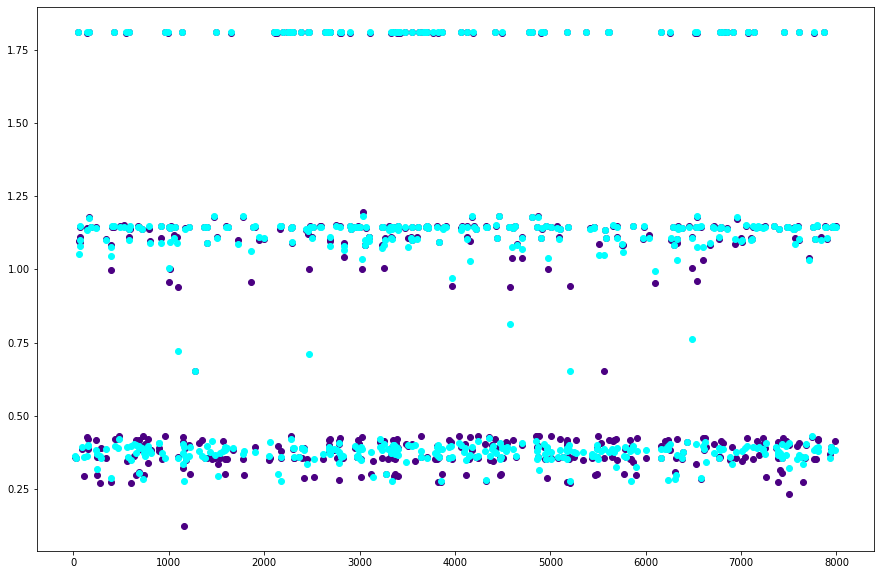

In [103]:
x = [random.randint(1, 8000) for i in range(len(y_sgd))]
plt.figure(figsize = (15, 10))
plt.scatter(x, test_y, color='#4B0082')
plt.scatter(x, y_g, color='cyan')
#plt.scatter(x, y_sgd, color='yellow')
plt.show()

In [57]:
test_y

614279304e27a1844a5f0810    1.1451
6141d809ee0a3fd43fb47bdf    0.2773
6142191a31cf3ef3d4a9f2f0    0.4159
6141d03e31cf3ef3d4a9edfc    0.3530
614229933ac25c70a5c6cafd    0.4175
                             ...  
61421e50ee0a3fd43fb47eaf    0.3511
6142d48f4e27a1844a5f0948    1.1466
6141f0c4baaf234b352904f6    1.1088
6141d3e94e27a1844a5f0190    1.1479
61425fad31cf3ef3d4a9f4b4    0.4079
Name: targets, Length: 594, dtype: float64